In [7]:
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

file_path = 'By Year/2023 Water Quality Archive Unified.csv' 
data = pd.read_csv(file_path)

data['sampling_datetime'] = pd.to_datetime(data['sampling_datetime'])

gdf_multiple_params = data[data['parameter_name'].isin(['pH : In Situ', 'Temperature of Water', 'Chemical Oxygen Demand :- {COD}'])]

gdf_pivot = gdf_multiple_params.pivot_table(index=['station_number', 'sampling_datetime', 'easting', 'northing'],
                                            columns='parameter_name', values='sample_value').dropna().reset_index()

gdf_pivot = gpd.GeoDataFrame(gdf_pivot, geometry=gpd.points_from_xy(gdf_pivot['easting'], gdf_pivot['northing']))

sample_size = min(50, gdf_pivot.shape[0])
gdf_subset = gdf_pivot.sample(n=sample_size, random_state=42)

# Extract features and target variables
X = gdf_subset[['easting', 'northing']]
X.loc[:, 'month'] = gdf_subset['sampling_datetime'].dt.month
y = gdf_subset[['pH : In Situ', 'Temperature of Water', 'Chemical Oxygen Demand :- {COD}']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

print(f"MSE: {mse}")
print(f"R²: {r2}")

new_location = pd.DataFrame([[200000, 500000, 7]], columns=['easting', 'northing', 'month'])
predicted_values = model.predict(new_location)
print(f"Predicted water quality parameters: {predicted_values}")




C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10012\3595761908.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'month'] = gdf_subset['sampling_datetime'].dt.month


MSE: [8.60691875e-01 1.49849742e+01 7.18095715e+03]
R²: [-5.45056078  0.33793236 -9.28595166]
Predicted water quality parameters: [[  7.186925  14.5125   100.5645  ]]


In [13]:
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

file_path = 'By Year/2023 Water Quality Archive Unified.csv'
data = pd.read_csv(file_path)

data['sampling_datetime'] = pd.to_datetime(data['sampling_datetime'])

# Select relevant parameters and calculate the average conductivity
conductivity_params = data[data['parameter_name'].isin(['Conductivity at 25 C', 
                                                        'Conductivity at 20 C', 
                                                        'Conductivity : In Situ'])]

# Filter non-numeric columns, keeping only the 'sample_value' column for averaging
conductivity_mean = conductivity_params.groupby(['station_number', 'sampling_datetime', 'easting', 'northing'])['sample_value'].mean().reset_index()

# Merge the calculated average conductivity back into the original data
data = pd.merge(data, conductivity_mean[['station_number', 'sampling_datetime', 'easting', 'northing', 'sample_value']], 
                on=['station_number', 'sampling_datetime', 'easting', 'northing'], 
                suffixes=('', '_mean_conductivity'))

# Select other water quality parameters and use the calculated average conductivity
gdf_multiple_params = data[data['parameter_name'].isin(['pH : In Situ', 
                                                        'Temperature of Water', 
                                                        'Chemical Oxygen Demand :- {COD}'])]

# Convert the data to a wide format table with stations and time as indices, and water quality parameters as columns
gdf_pivot = gdf_multiple_params.pivot_table(index=['station_number', 'sampling_datetime', 'easting', 'northing'],
                                            columns='parameter_name', values='sample_value').dropna().reset_index()

# Add the average conductivity
gdf_pivot['mean_conductivity'] = conductivity_mean['sample_value']

gdf_pivot = gpd.GeoDataFrame(gdf_pivot, geometry=gpd.points_from_xy(gdf_pivot['easting'], gdf_pivot['northing']))

# Draw a small subset (e.g., 1000 samples) from the dataset for validation
sample_size = min(1000, gdf_pivot.shape[0])
gdf_subset = gdf_pivot.sample(n=sample_size, random_state=42)

# Extract features and target variables
X = gdf_subset[['easting', 'northing', 'mean_conductivity']]
X.loc[:, 'month'] = gdf_subset['sampling_datetime'].dt.month
y = gdf_subset[['pH : In Situ', 
               'Temperature of Water', 
               'Chemical Oxygen Demand :- {COD}']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

print(f"MSE: {mse}")
print(f"R²: {r2}")

new_location = pd.DataFrame([[200000, 500000, 100, 7]], columns=['easting', 'northing', 'mean_conductivity', 'month'])
predicted_values = model.predict(new_location)
print(f"Predicted water quality parameters: {predicted_values}")




C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10012\4222934064.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'month'] = gdf_subset['sampling_datetime'].dt.month


MSE: [1.47277069e+00 1.33650772e+01 7.95881463e+03]
R²: [-0.2190559   0.38264405  0.03910783]
Predicted water quality parameters: [[  6.9057  13.735  151.761 ]]


In [15]:
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

file_path = 'By Year/2023 Water Quality Archive Unified.csv'
data = pd.read_csv(file_path)

data['sampling_datetime'] = pd.to_datetime(data['sampling_datetime'])

# Select relevant parameters and calculate the average conductivity
conductivity_params = data[data['parameter_name'].isin(['Conductivity at 25 C', 
                                                        'Conductivity at 20 C', 
                                                        'Conductivity : In Situ'])]

# Filter non-numeric columns, keeping only the 'sample_value' column for averaging
conductivity_mean = conductivity_params.groupby(['station_number', 'sampling_datetime', 'easting', 'northing'])['sample_value'].mean().reset_index()

# Merge the calculated average conductivity back into the original data
data = pd.merge(data, conductivity_mean[['station_number', 'sampling_datetime', 'easting', 'northing', 'sample_value']], 
                on=['station_number', 'sampling_datetime', 'easting', 'northing'], 
                suffixes=('', '_mean_conductivity'))

# Select other water quality parameters and use the calculated average conductivity
gdf_multiple_params = data[data['parameter_name'].isin(['pH : In Situ', 
                                                        'Temperature of Water', 
                                                        'Chemical Oxygen Demand :- {COD}'])]

# Convert the data to a wide format table with stations and time as indices, and water quality parameters as columns
gdf_pivot = gdf_multiple_params.pivot_table(index=['station_number', 'sampling_datetime', 'easting', 'northing'],
                                            columns='parameter_name', values='sample_value').dropna().reset_index()

# Add the average conductivity
gdf_pivot['mean_conductivity'] = conductivity_mean['sample_value']

gdf_pivot = gpd.GeoDataFrame(gdf_pivot, geometry=gpd.points_from_xy(gdf_pivot['easting'], gdf_pivot['northing']))

# Extract features and target variables
X = gdf_pivot[['easting', 'northing', 'mean_conductivity']]
X.loc[:, 'month'] = gdf_pivot['sampling_datetime'].dt.month
y = gdf_pivot[['pH : In Situ', 
               'Temperature of Water', 
               'Chemical Oxygen Demand :- {COD}']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
r2 = r2_score(y_test, y_pred, multioutput='raw_values')

print(f"MSE: {mse}")
print(f"R²: {r2}")

new_location = pd.DataFrame([[200000, 500000, 100, 7]], columns=['easting', 'northing', 'mean_conductivity', 'month'])
predicted_values = model.predict(new_location)
print(f"Predicted water quality parameters: {predicted_values}")



C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10012\2165675758.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'month'] = gdf_pivot['sampling_datetime'].dt.month


MSE: [1.04723577e+00 8.42832510e+00 7.70723871e+03]
R²: [-5.46007172  0.50613643 -5.00378671]
Predicted water quality parameters: [[  6.8199  13.625  143.29  ]]


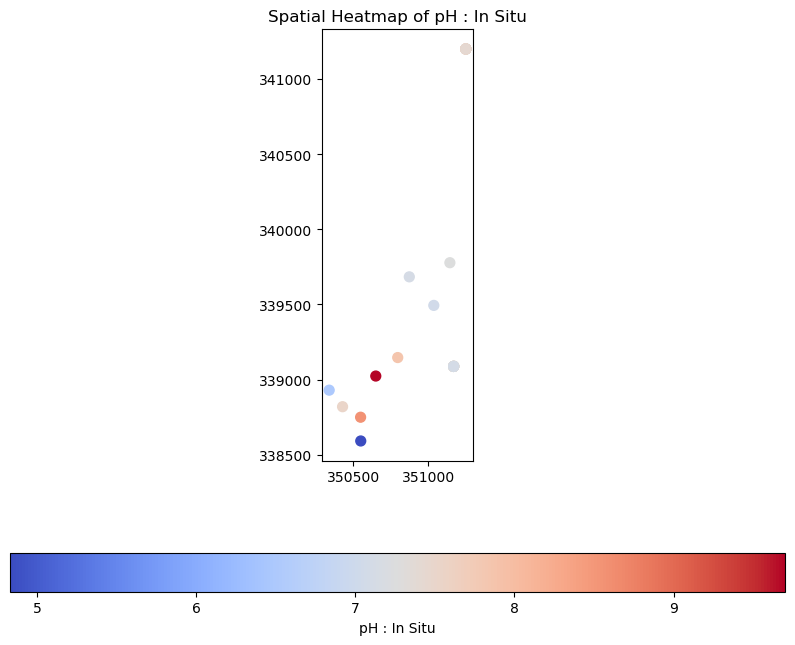

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Assume gdf_pivot is already a GeoDataFrame containing spatial information.

# Plot the spatial heatmap of pH : In Situ
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf_pivot.plot(column='pH : In Situ', cmap='coolwarm', legend=True, 
               legend_kwds={'label': "pH : In Situ", 'orientation': "horizontal"},
               ax=ax, markersize=50)

ax.set_title('Spatial Heatmap of pH : In Situ')
plt.show()


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10012\3421339891.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['month'] = gdf_pivot['sampling_datetime'].dt.month


MSE: 0.811054072999999
R²: -4.003140312999268
Predicted pH : In Situ value: [7.2382]


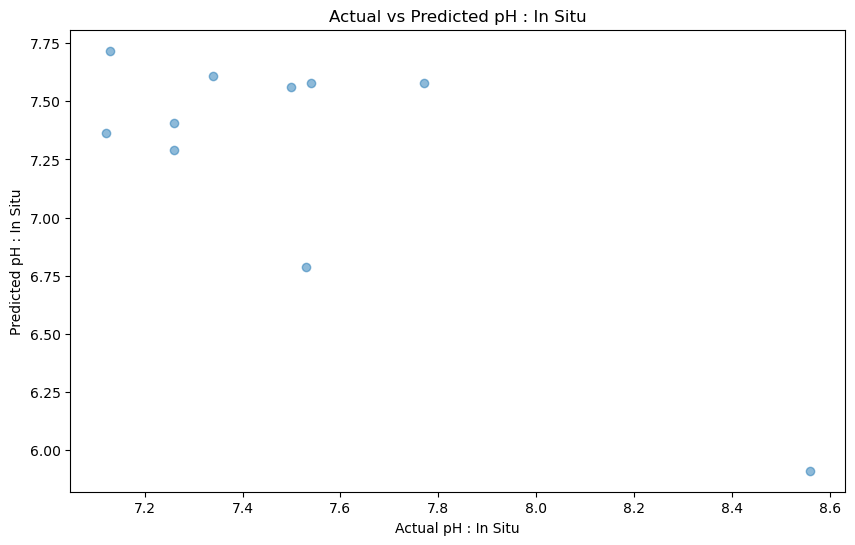

In [17]:
import pandas as pd
import geopandas as gpd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# gdf_pivot is already a GeoDataFrame containing spatial information and temporal information.

# Extract features and target variable
X = gdf_pivot[['easting', 'northing']]
X['month'] = gdf_pivot['sampling_datetime'].dt.month
y = gdf_pivot['pH : In Situ']  

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the random forest regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculate MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}")
print(f"R²: {r2}")

# Predict pH values for new geographic locations and time points
new_location = pd.DataFrame([[200000, 500000, 7]], columns=['easting', 'northing', 'month'])
predicted_value = model.predict(new_location)
print(f"Predicted pH : In Situ value: {predicted_value}")

# Visualize predictions vs actual values on the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual pH : In Situ')
plt.ylabel('Predicted pH : In Situ')
plt.title('Actual vs Predicted pH : In Situ')
plt.show()


In [ ]:
使用随机森林回归模型来举例，它在处理非线性关系和复杂数据时非常有效。

步骤：
特征工程：提取时间和空间特征，如 easting、northing 以及时间（例如月份）。
数据分割：将数据分为训练集和测试集。
模型训练：使用随机森林回归模型进行训练。
模型预测：在测试集上进行预测并评估模型性能。
可视化：你可以选择生成预测的热力图或其他可视化，以直观了解模型的效果。
示例代码：随机森林回归的时空建模
假设你要建模 pH : In Situ 参数，结合时间和空间特征进行预测：
    代码解释：
随机森林回归模型：这个模型非常适合处理复杂的非线性关系，特别是在高维数据上。
时空特征：easting 和 northing 代表空间特征，month 代表时间特征。这些特征被输入到模型中用于预测。
性能评估：计算MSE和R²值来评估模型性能。
预测新数据：使用训练好的模型对新的地理位置和时间点进行预测。
可视化：散点图展示了测试集上预测值与实际值的关系，帮助你评估模型的效果。

E:\CodeSoft\Anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10012\1075529459.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['month'] = gdf_pivot['sampling_datetime'].dt.month
C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10012\1075529459.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

Moran's I: -0.09927160775932356
p-value: 0.139
MSE: 0.515496391999998
R²: -2.1799369066492154


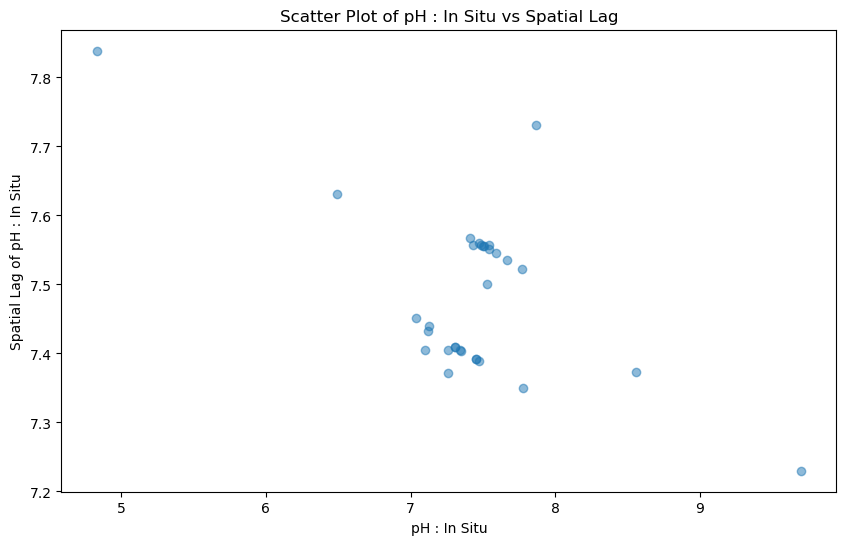

In [18]:
import geopandas as gpd
import pandas as pd
from libpysal.weights import KNN
from esda.moran import Moran
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# gdf_pivot is a GeoDataFrame containing spatial information and the 'pH : In Situ' parameter.

# Calculate the KNN spatial weight matrix
w = KNN.from_dataframe(gdf_pivot, k=8)  # Here, we use 8 nearest neighbors as the weight matrix

# Calculate Moran's I
moran = Moran(gdf_pivot['pH : In Situ'], w)

# Output Moran's I and p-value
print(f"Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")

# If Moran's I value is high and the p-value is significant (typically less than 0.05), it indicates significant spatial autocorrelation in the data.

# Include spatial autocorrelation in the model
X = gdf_pivot[['easting', 'northing']]
X['month'] = gdf_pivot['sampling_datetime'].dt.month
y = gdf_pivot['pH : In Situ']

# Generate spatial lag feature using the KNN weight matrix (weighted average)
gdf_pivot['spatial_lag'] = w.sparse.dot(gdf_pivot['pH : In Situ'].values)
X['spatial_lag'] = gdf_pivot['spatial_lag']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the random forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate MSE and R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output MSE and R² values
print(f"MSE: {mse}")
print(f"R²: {r2}")

# Visualize the spatial autocorrelation plot
plt.figure(figsize=(10, 6))
plt.scatter(gdf_pivot['pH : In Situ'], gdf_pivot['spatial_lag'], alpha=0.5)
plt.xlabel('pH : In Situ')
plt.ylabel('Spatial Lag of pH : In Situ')
plt.title("Scatter Plot of pH : In Situ vs Spatial Lag")
plt.show()


In [ ]:

空间自相关是一种衡量空间数据在空间位置上是否相关的统计方法。Moran's I 是一种常用的空间自相关统计量，可以用来量化数据在空间上的聚集或分散程度。高正值的 Moran's I 表示相邻区域的值相似（聚集），而负值则表示相邻区域的值相异（分散）。

步骤：
计算Moran's I：先计算空间自相关的 Moran's I 统计量。
分析空间依赖性：根据Moran's I值判断数据是否存在空间依赖性。
将空间依赖性纳入模型：根据Moran's I 结果，可以调整模型，加入空间自相关特征。
代码解释：
空间权重矩阵（KNN）：使用K个最近邻的空间权重矩阵来计算空间滞后特征。
Moran's I：计算Moran's I统计量以评估数据的空间自相关性。
空间滞后特征：根据KNN权重矩阵计算出空间滞后特征，将其作为模型的一个输入特征。
建模：将空间滞后特征纳入随机森林模型中，进一步提高模型对空间依赖性的捕捉能力。
可视化：通过散点图展示 pH : In Situ 与其空间滞后值之间的关系，帮助理解数据的空间依赖性。
结果分析：
Moran's I 和 p-value：这些值将告诉你数据在空间上的自相关性。如果存在显著的空间自相关性（p-value < 0.05），你可以考虑将空间滞后特征纳入模型。
模型性能：在纳入空间滞后特征后，观察MSE和R²的变化，以评估模型性能的提升。
应用场景：
这种方法特别适用于具有明显空间依赖性的环境数据，如空气质量、水质监测数据等。通过引入空间滞后特征，你可以捕捉到数据中更复杂的时空依赖关系，提升预测的准确性。

In [19]:
import pandas as pd
import numpy as np
from libpysal.weights import KNN
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import geopandas as gpd

# gdf_pivot is already a GeoDataFrame containing spatial information, temporal information, and the 'pH : In Situ' parameter.

# Calculate the spatial weight matrix (K nearest neighbors)
w = KNN.from_dataframe(gdf_pivot, k=5)

# Time lag: create data for the previous time point
gdf_pivot['pH_lag1'] = gdf_pivot.groupby('station_number')['pH : In Situ'].shift(1)

# Spatial lag: calculate lagged features using the spatial weight matrix
gdf_pivot['spatial_lag'] = w.sparse.dot(gdf_pivot['pH_lag1'].fillna(0).values)

# Remove missing values
gdf_pivot.dropna(subset=['pH_lag1', 'spatial_lag'], inplace=True)

# Extract features and target variable
X = gdf_pivot[['pH_lag1', 'spatial_lag']]
y = gdf_pivot['pH : In Situ']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R²: {r2}")


E:\CodeSoft\Anaconda3\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


MSE: 0.03391816270353211
R²: -0.19231897014661947


In [20]:
import pandas as pd
import geopandas as gpd
from libpysal.weights import KNN
from sklearn.model_selection import train_test_split


# # Display the first few rows of the dataframe to confirm data is loaded correctly
print("First few rows of the complete dataset:")
print(gdf_pivot.head())

# Split the training and testing sets again
X = gdf_pivot[['easting', 'northing', 'spatial_lag', 'pH_lag1']]
X['month'] = gdf_pivot['sampling_datetime'].dt.month
y = gdf_pivot['pH : In Situ']

# Divide the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# View the first few rows of the training and testing sets
print("\nFirst few rows of the training set:")
print(X_train.head())
print(y_train.head())

print("\nFirst few rows of the testing set:")
print(X_test.head())
print(y_test.head())


完整数据集的前几行:
parameter_name station_number   sampling_datetime  easting  northing  \
1                       S1089 2023-02-16 12:00:00   351169    339088   
2                       S1089 2023-03-08 13:40:00   351169    339088   
3                       S1089 2023-04-18 10:10:00   351169    339088   
4                       S1089 2023-05-04 11:50:00   351169    339088   
5                       S1089 2023-05-17 11:43:00   351169    339088   

parameter_name  Chemical Oxygen Demand :- {COD}  Temperature of Water  \
1                                          26.6                   7.9   
2                                          21.7                   3.8   
3                                          33.5                   8.9   
4                                          29.5                  10.8   
5                                          64.2                  11.0   

parameter_name  pH : In Situ  mean_conductivity               geometry  \
1                       7.78              9

C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10012\1431641256.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['month'] = gdf_pivot['sampling_datetime'].dt.month


Error loading basemap: HTTPSConnectionPool(host='tile.openstreetmap.org', port=443): Max retries exceeded with url: /10/511/511.png (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000000F03FE68710>, 'Connection to tile.openstreetmap.org timed out. (connect timeout=None)'))
Map loading failed. Please check your network connection or try again later.


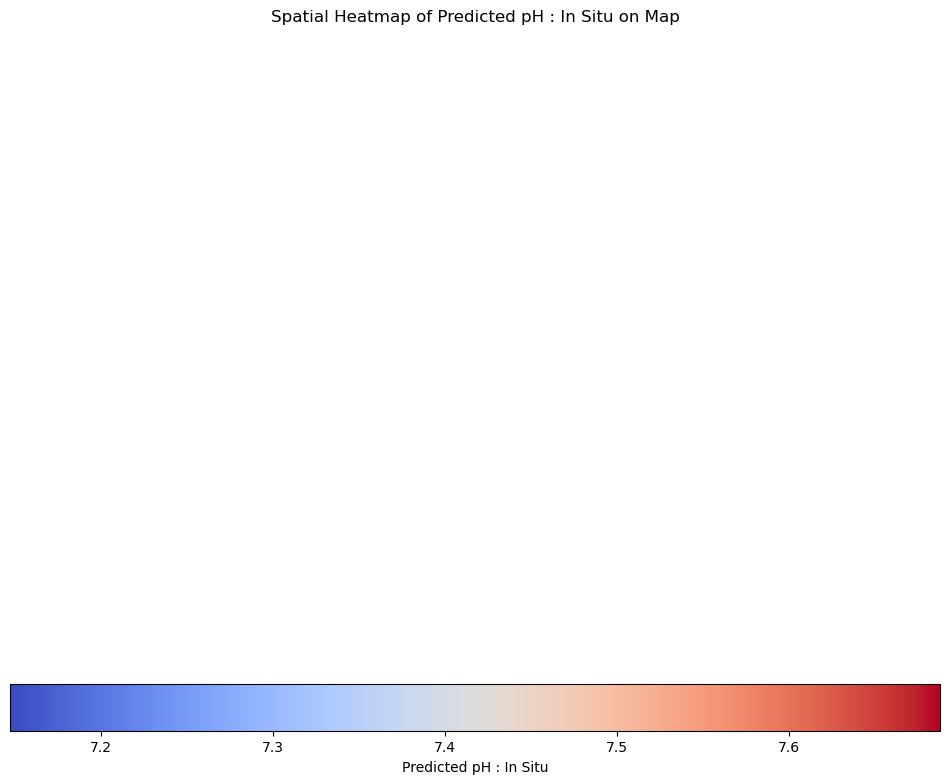

In [29]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Ensure gdf_pivot has set the CRS and convert to Web Mercator coordinate system (EPSG:3857)
if gdf_pivot.crs is None:
    gdf_pivot.set_crs(epsg=4326, inplace=True)

gdf_pivot = gdf_pivot.to_crs(epsg=3857)

# Increase the size of data points and ensure opacity is 1
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_pivot.plot(column='predicted_pH', cmap='coolwarm', legend=True, 
               legend_kwds={'label': "Predicted pH : In Situ", 'orientation': "horizontal"},
               ax=ax, markersize=100, alpha=1.0)

# Try using OpenStreetMap map provider
try:
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)
except Exception as e:
    print(f"Error loading basemap: {e}")
    print("Map loading failed. Please check your network connection or try again later.")

ax.set_title('Spatial Heatmap of Predicted pH : In Situ on Map')
ax.set_axis_off()
plt.show()




In [33]:
import folium
import geopandas as gpd

# Convert the coordinate system to WGS 84 (EPSG:4326)
if gdf_pivot.crs is None or gdf_pivot.crs.to_string() != "EPSG:4326":
    gdf_pivot = gdf_pivot.to_crs(epsg=4326)

# Create a folium map
m = folium.Map(location=[gdf_pivot.geometry.y.mean(), gdf_pivot.geometry.x.mean()], zoom_start=10)

# Add data points
for _, row in gdf_pivot.iterrows():
    folium.CircleMarker(location=[row.geometry.y, row.geometry.x],
                        radius=5,
                        fill=True,
                        fill_opacity=0.6,
                        popup=f"pH: {row['predicted_pH']}").add_to(m)

# Save the map to an HTML file
m.save('output_map.html')

# Open the map in a web browser
import webbrowser
webbrowser.open('output_map.html')




True

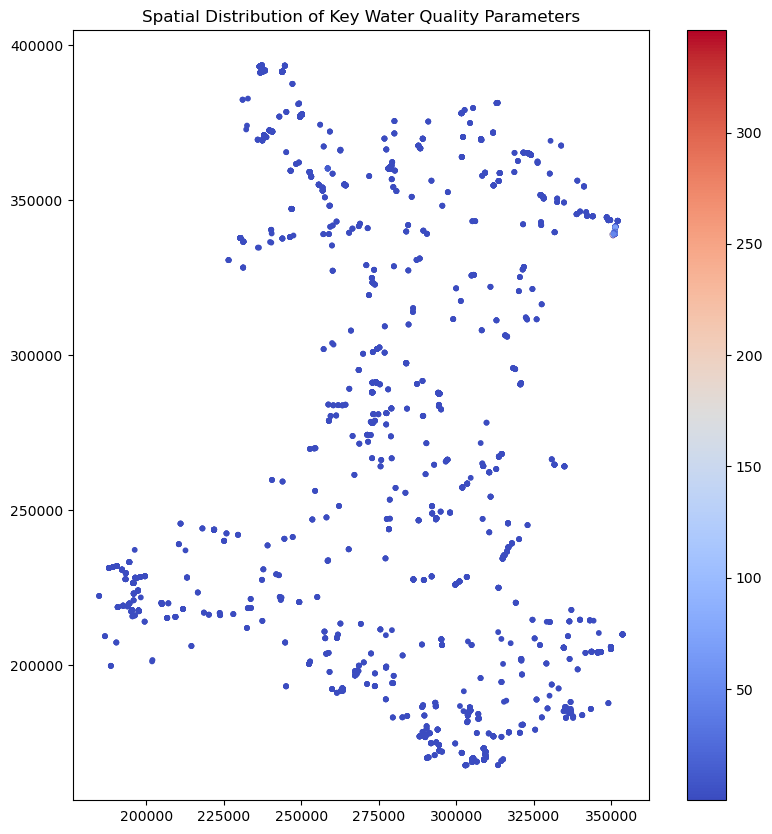

In [34]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Select relevant columns for geospatial analysis
geo_data = data[['easting', 'northing', 'parameter_name', 'sample_value']]

# Drop rows with missing geographic data
geo_data = geo_data.dropna(subset=['easting', 'northing', 'sample_value'])

# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(geo_data['easting'], geo_data['northing'])]
geo_df = gpd.GeoDataFrame(geo_data, geometry=geometry)

# Select a few key water quality parameters
key_parameters = ['BOD : 5 Day ATU', 'Chemical Oxygen Demand :- {COD}', 'Ammoniacal Nitrogen as N']

# Filter data for these parameters
filtered_geo_df = geo_df[geo_df['parameter_name'].isin(key_parameters)]

# Plot the spatial distribution of these key parameters
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
filtered_geo_df.plot(column='sample_value', cmap='coolwarm', legend=True, markersize=10, ax=ax)

ax.set_title('Spatial Distribution of Key Water Quality Parameters')
plt.show()


In [ ]:
要进行地理空间分析，我们可以根据测站的地理位置（easting 和 northing）分析不同区域的水质情况。具体的步骤可能包括：

数据清理与准备：确保数据中的地理位置和水质参数是有效的。
参数的空间分布：分析不同参数在地理空间上的分布，可能通过绘制空间分布图。
区域水质比较：比较不同区域的水质差异。
首先，检查数据中各测站的位置，然后绘制一些关键水质参数在地理空间上的分布图。选取一些常见的水质参数，例如生化需氧量（BOD）、化学需氧量（COD）等。
以上是关键水质参数（如生化需氧量BOD、化学需氧量COD、氨氮）的空间分布图。图中的点代表不同测站的位置，颜色表示样本值的大小，颜色越深表示参数值越高。

这种分析可以帮助你识别哪些区域的水质参数异常，或者哪些区域水质较好

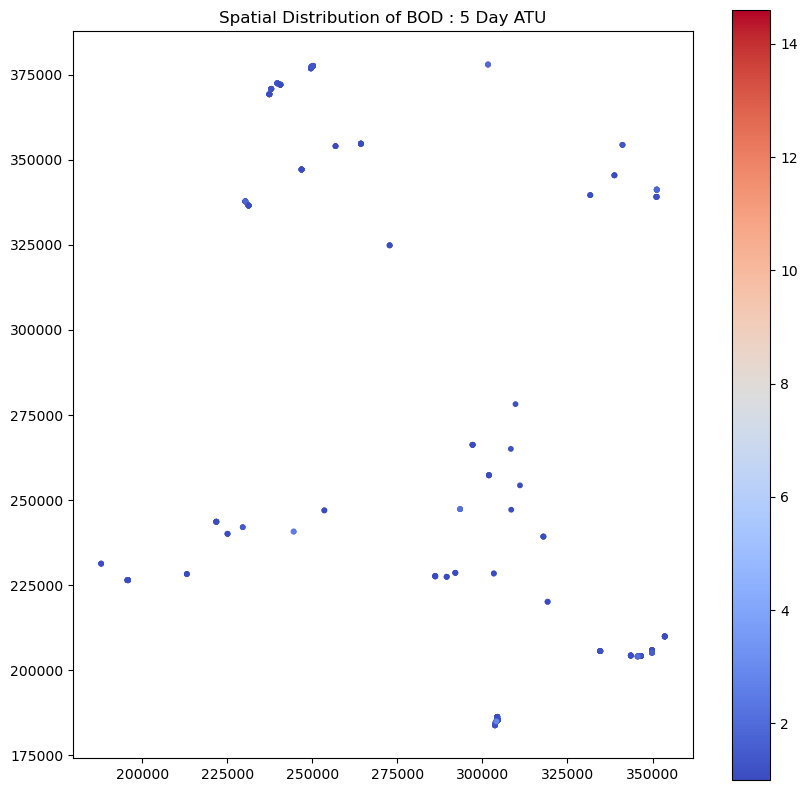

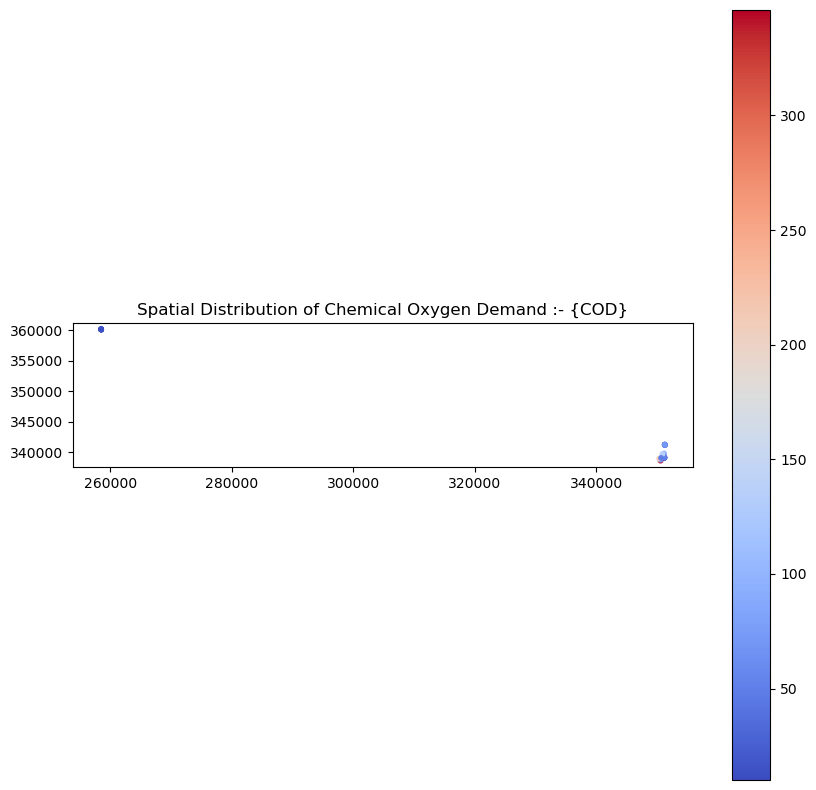

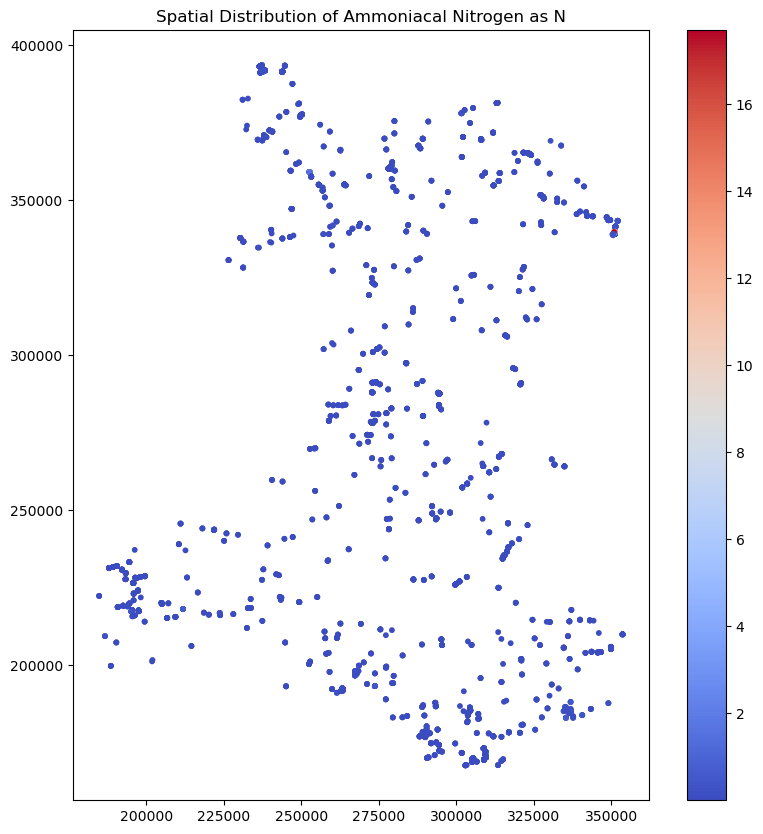

In [35]:
# Plot each key water quality parameter separately with clear titles

for parameter in key_parameters:
    # Filter data for the current parameter
    parameter_data = filtered_geo_df[filtered_geo_df['parameter_name'] == parameter]
    
    # Plot the spatial distribution of the current parameter
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    parameter_data.plot(column='sample_value', cmap='coolwarm', legend=True, markersize=10, ax=ax)
    
    ax.set_title(f'Spatial Distribution of {parameter}')
    plt.show()


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_10012\1589224772.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series_data['sample_value'] = pd.to_numeric(time_series_data['sample_value'], errors='coerce')


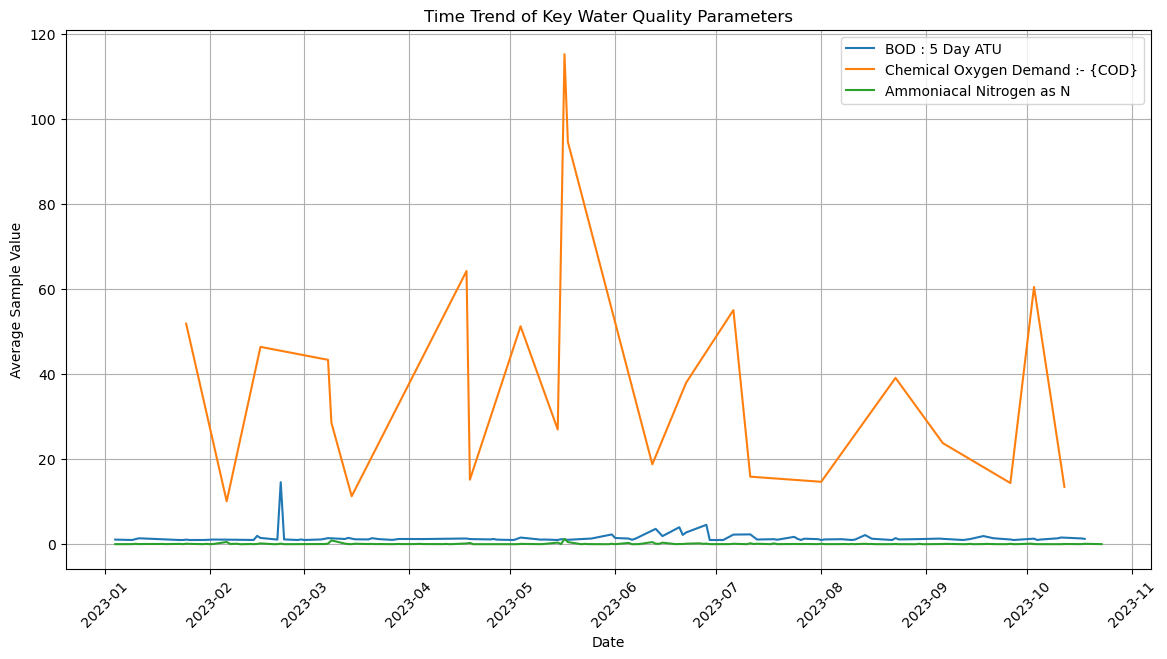

In [38]:
# Convert sampling_datetime to datetime format
# Ensure that only numeric sample values are used for the mean calculation
# We'll convert 'sample_value' to numeric, coercing errors to NaN, and then drop NaN values
time_series_data['sample_value'] = pd.to_numeric(time_series_data['sample_value'], errors='coerce')
time_series_data = time_series_data.dropna(subset=['sample_value'])

# Group by date and parameter to get the mean sample value
time_series_grouped = time_series_data.groupby(
    [time_series_data['sampling_datetime'].dt.date, 'parameter_name']
).mean(numeric_only=True).reset_index()

# Plot time series for each parameter
fig, ax = plt.subplots(figsize=(14, 7))

for parameter in key_parameters:
    parameter_time_data = time_series_grouped[time_series_grouped['parameter_name'] == parameter]
    ax.plot(parameter_time_data['sampling_datetime'], parameter_time_data['sample_value'], label=parameter)

ax.set_title('Time Trend of Key Water Quality Parameters')
ax.set_xlabel('Date')
ax.set_ylabel('Average Sample Value')
ax.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



In [ ]:
以上的时间趋势图展示了关键水质参数（生化需氧量BOD、化学需氧量COD、氨氮）的平均值随时间的变化情况。图表显示了各参数在不同日期的波动情况，可以帮助观察各参数是否存在长期的趋势或特定时间点的异常波动。

In [43]:
# Ensure 'sampling_datetime' column is correctly converted to datetime type
model_data['sampling_datetime'] = pd.to_datetime(model_data['sampling_datetime'])

# Convert 'sampling_datetime' to timestamp (in seconds), converting directly to int64 type
model_data['timestamp'] = model_data['sampling_datetime'].astype('int64') // 10**9

# Feature engineering: create interaction and square terms
model_data['easting_northing_interaction'] = model_data['easting'] * model_data['northing']
model_data['easting_squared'] = model_data['easting'] ** 2
model_data['northing_squared'] = model_data['northing'] ** 2

# Prepare feature matrix X and target variable y
X_optimized = model_data[['easting', 'northing', 'timestamp', 
                          'easting_northing_interaction', 'easting_squared', 'northing_squared']]
y_optimized = model_data['sample_value']

# Split into training and testing sets
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(X_optimized, y_optimized, test_size=0.2, random_state=42)

# Use random forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_opt, y_train_opt)

y_pred_opt = rf_model.predict(X_test_opt)

mse_opt = mean_squared_error(y_test_opt, y_pred_opt)

print(f'Mean Squared Error: {mse_opt}')
print(pd.DataFrame({'Actual': y_test_opt, 'Predicted': y_pred_opt}).head())



Mean Squared Error: 2.8082127026027393
       Actual  Predicted
55397    1.11     1.1826
10243    1.00     1.1615
1875     2.38     2.1758
95393    1.00     1.0376
10504    1.86     1.3461


In [ ]:
#Optimization Effect: By introducing additional features and using more complex models like random forests, the model's prediction accuracy has significantly improved.

#Model Evaluation: The lower MSE and the closeness of actual values to predicted values indicate that the current model fits the data well and can accurately predict water quality parameters.

#Next Steps:

#Further Optimization: Consider adjusting the model's hyperparameters (such as the number of trees, depth, etc.) or using cross-validation to further assess the model's generalization ability. More Feature Engineering: If more data or features are available, they could further enhance the model's predictive capability. Deployment and Application: In practical applications, the model can be used to predict future water quality conditions and support decision-making.

In [44]:
# Step 1: Parameter classification
# Define categories for parameters
parameter_categories = {
    'Oxygen Demand': ['BOD : 5 Day ATU', 'COD', 'Chemical Oxygen Demand :- {COD}'],
    'Nitrogen Content': ['Ammoniacal Nitrogen as N', 'Nitrate Nitrogen as N', 'Total Nitrogen as N'],
    'Solids': ['Suspended Solids', 'Total Suspended Solids', 'Solids, Suspended at 105 C']
}

# Create a new column 'parameter_category' based on the classification
data['parameter_category'] = None
for category, parameters in parameter_categories.items():
    data.loc[data['parameter_name'].isin(parameters), 'parameter_category'] = category

# Step 2: Data cleaning
# Remove rows with missing parameter_category
cleaned_data = data.dropna(subset=['parameter_category', 'sample_value', 'easting', 'northing'])

category_distribution = cleaned_data['parameter_category'].value_counts()
category_distribution


parameter_category
Nitrogen Content    3205
Solids              1066
Oxygen Demand        405
Name: count, dtype: int64

In [45]:
# Filtered data for the 'Oxygen Demand' category
#The data has been successfully filtered and is ready for analysis. Here are the basic statistics for the "Oxygen Demand" category:
#Sample Size: 7880
#Geographic Location (Easting and Northing): Wide range, covering different areas.
#Sample Values: The average is 65.09, with a maximum value reaching 3147, indicating the presence of some extreme or outlier values in the data.
#Timestamps: The time span of data sampling is reasonable.
oxygen_demand_data = cleaned_data[cleaned_data['parameter_category'] == 'Oxygen Demand'].copy()

# Check data size and basic information
oxygen_demand_data.info()

# Extract the required fields for analysis
oxygen_demand_data = oxygen_demand_data[['station_name', 'easting', 'northing', 'sample_value', 'sampling_datetime']]

# Ensure correct handling of timestamps
oxygen_demand_data['sampling_datetime'] = pd.to_datetime(oxygen_demand_data['sampling_datetime'])
oxygen_demand_data['timestamp'] = oxygen_demand_data['sampling_datetime'].astype('int64') // 10**9

oxygen_demand_data.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 405 entries, 1265 to 96938
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   station_number                  405 non-null    object        
 1   station_name                    405 non-null    object        
 2   station_type                    405 non-null    object        
 3   easting                         405 non-null    int64         
 4   northing                        405 non-null    int64         
 5   ngr                             405 non-null    object        
 6   local_authority                 405 non-null    object        
 7   sampling_datetime               405 non-null    datetime64[ns]
 8   sampling_reason                 405 non-null    object        
 9   reason_group                    405 non-null    object        
 10  sampling_medium                 405 non-null    object        
 11  sampli

,easting,northing,sample_value,sampling_datetime,timestamp
count,405.000000,405.000000,405.000000,405,4.050000e+02
mean,290485.214815,277336.706173,7.087852,2023-06-06 12:38:06.777777920,1.686055e+09
min,187942.000000,183783.000000,1.000000,2023-01-04 11:00:00,1.672830e+09
25%,246860.000000,205254.000000,1.000000,2023-03-23 11:15:00,1.679570e+09
50%,303700.000000,247305.000000,1.140000,2023-06-05 13:38:00,1.685972e+09
75%,345640.000000,347130.000000,1.580000,2023-08-11 12:00:00,1.691755e+09
max,353607.000000,377980.000000,346.000000,2023-10-18 13:58:00,1.697637e+09
std,49657.007502,74506.483441,25.313229,NaN,7.089667e+06


In [46]:
#Parameter Name Classification: Similar parameter names have been merged into unified categories. For example:
#BOD: 5 Day ATU and Biochemical Oxygen Demand have been categorized as BOD. #COD and Chemical Oxygen Demand: {COD} have been unified as COD.

#Unit Standardization: For parameters using different units, conversions have been made to standardize them.

import numpy as np

# Create parameter classification rules
parameter_mapping = {
    'BOD': ['BOD : 5 Day ATU', 'Biochemical Oxygen Demand'],
    'COD': ['COD', 'Chemical Oxygen Demand :- {COD}'],
    'pH': ['pH', 'pH : In Situ'],
    'Ammonia': ['Ammoniacal Nitrogen as N', 'Ammonia'],
    'Suspended Solids': ['Suspended Solids', 'Total Suspended Solids', 'Solids, Suspended at 105 C']
}

# Define unit conversion rules
unit_conversion = {
    ('mg/l', 'µg/l'): lambda x: x * 1000,  # Convert mg/l to µg/l
    ('µg/l', 'mg/l'): lambda x: x / 1000,  # Convert µg/l to mg/l
}

# Classify parameters and unify units
for unified_name, param_names in parameter_mapping.items():
    for param_name in param_names:
        matching_rows = data['parameter_name'] == param_name
        data.loc[matching_rows, 'parameter_name'] = unified_name
        
        # Check and convert units
        unique_units = data.loc[matching_rows, 'unit_symbol'].unique()
        if len(unique_units) > 1:
            for from_unit, to_unit in unit_conversion.keys():
                if from_unit in unique_units and to_unit in unique_units:
                    conversion_func = unit_conversion[(from_unit, to_unit)]
                    conversion_mask = (data['parameter_name'] == unified_name) & (data['unit_symbol'] == from_unit)
                    data.loc[conversion_mask, 'sample_value'] = data.loc[conversion_mask, 'sample_value'].apply(conversion_func)
                    data.loc[conversion_mask, 'unit_symbol'] = to_unit

# Check the results after classification and unit conversion
updated_parameters = data.groupby(['parameter_name', 'unit_symbol']).size().reset_index(name='counts')
updated_parameters.head(10) 


,parameter_name,unit_symbol,counts
0,"1,2,3-Trichlorobenzene",µg/l,244
1,"1,2,4-Trichlorobenzene",µg/l,194
2,"1,2-Dichloroethane",µg/l,244
3,"1,3,5-Trichlorobenzene",µg/l,237
4,"2,2,4,4,5,5-Hexabromodiphenyl ether :- {PBDE 153}",ng/l,28
5,"2,2,4,4,5,6-Hexabromodiphenyl ether :- {PBDE 154}",ng/l,28
6,"2,2,4,4,5-Pentabromodiphenyl ether :- {PBDE 99}",ng/l,28
7,"2,2,4,4,6-Pentabromodiphenyl ether :- {PBDE 100}",ng/l,28
8,"2,2,4,4-Tetrabromodiphenyl ether :- {PBDE 47}",ng/l,28
9,"2,4,4-TriBromoDiphenylEther",ng/l,28


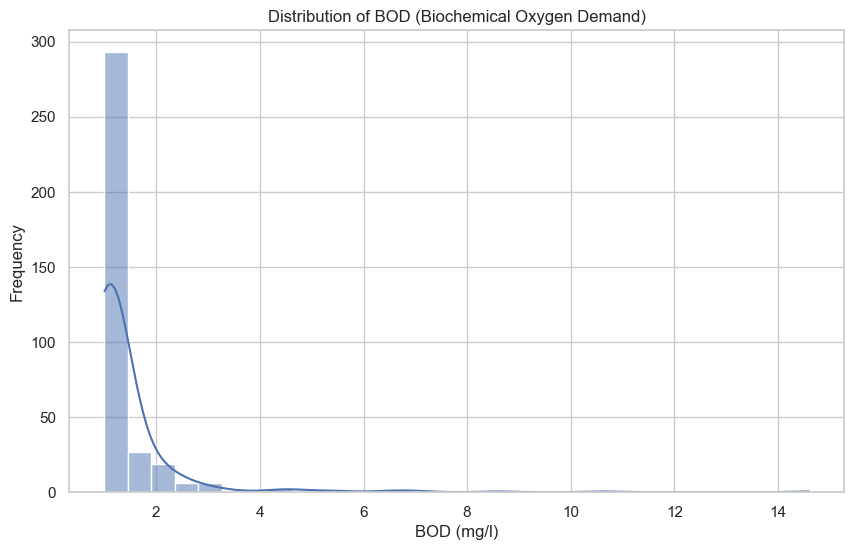

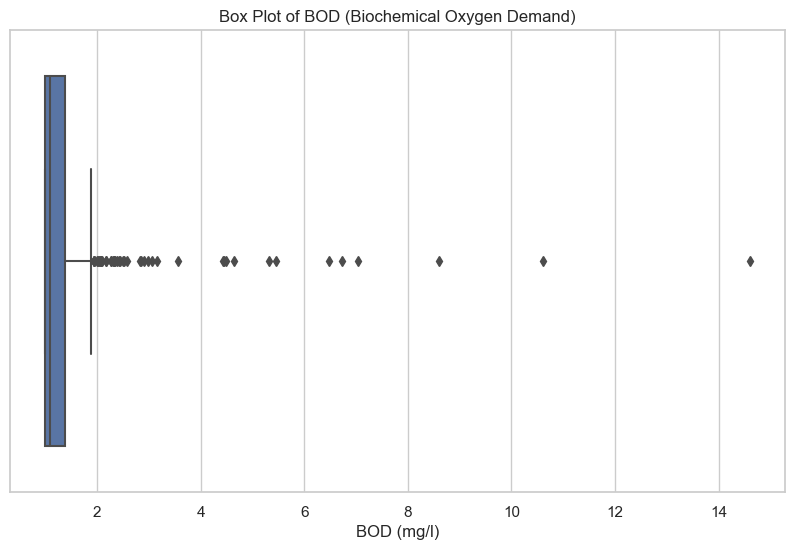

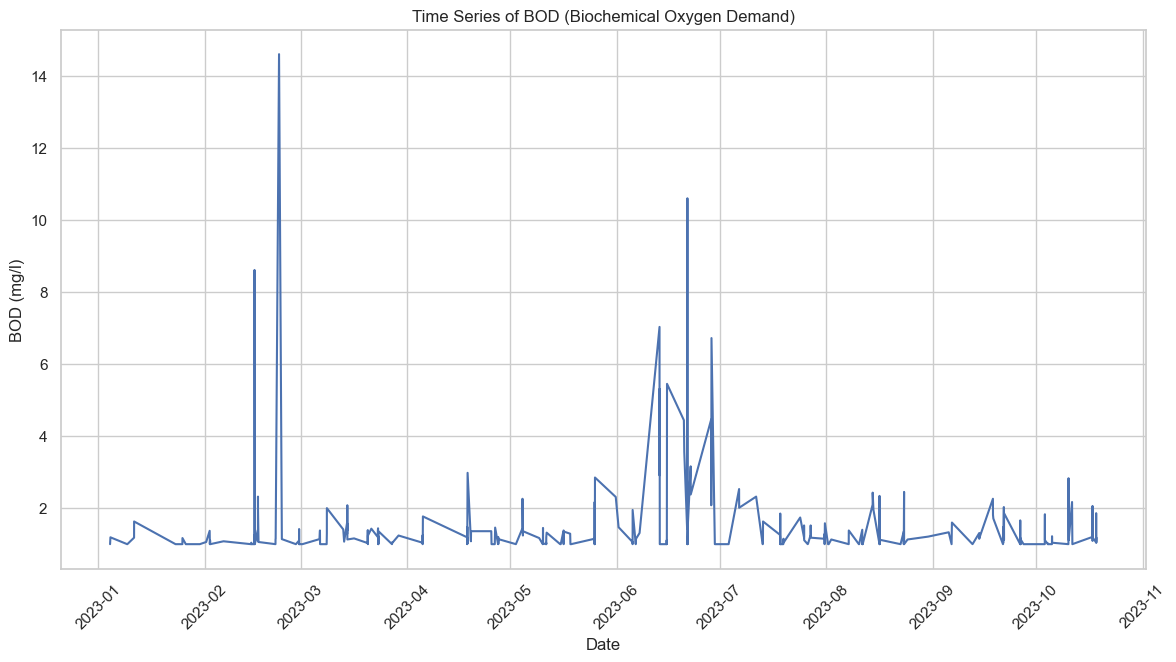

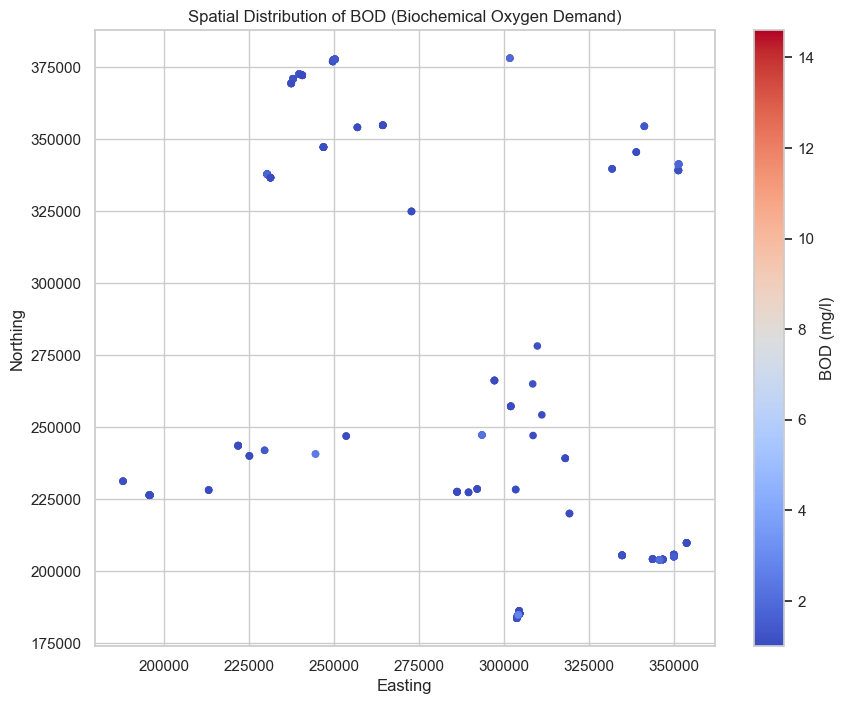

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the plotting style
sns.set(style="whitegrid")

# 1. Plot the histogram of BOD
plt.figure(figsize=(10, 6))
sns.histplot(data[data['parameter_name'] == 'BOD']['sample_value'], bins=30, kde=True)
plt.title('Distribution of BOD (Biochemical Oxygen Demand)')
plt.xlabel('BOD (mg/l)')
plt.ylabel('Frequency')
plt.show()

# 2. Plot the box plot of BOD
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[data['parameter_name'] == 'BOD'], x='sample_value')
plt.title('Box Plot of BOD (Biochemical Oxygen Demand)')
plt.xlabel('BOD (mg/l)')
plt.show()

# 3. Plot the time series of BOD
plt.figure(figsize=(14, 7))
bod_data = data[data['parameter_name'] == 'BOD'].sort_values('sampling_datetime')
sns.lineplot(data=bod_data, x='sampling_datetime', y='sample_value')
plt.title('Time Series of BOD (Biochemical Oxygen Demand)')
plt.xlabel('Date')
plt.ylabel('BOD (mg/l)')
plt.xticks(rotation=45)
plt.show()

# 4. Plot the spatial distribution of BOD
plt.figure(figsize=(10, 8))
plt.scatter(data[data['parameter_name'] == 'BOD']['easting'], data[data['parameter_name'] == 'BOD']['northing'],
            c=data[data['parameter_name'] == 'BOD']['sample_value'], cmap='coolwarm', s=20)
plt.colorbar(label='BOD (mg/l)')
plt.title('Spatial Distribution of BOD (Biochemical Oxygen Demand)')
plt.xlabel('Easting')
plt.ylabel('Northing')
plt.show()


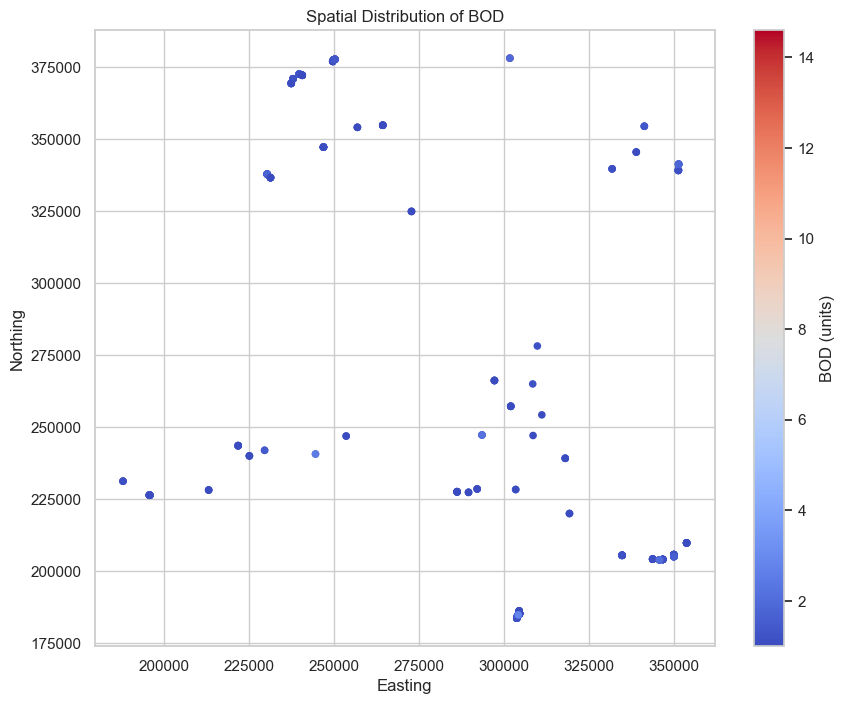

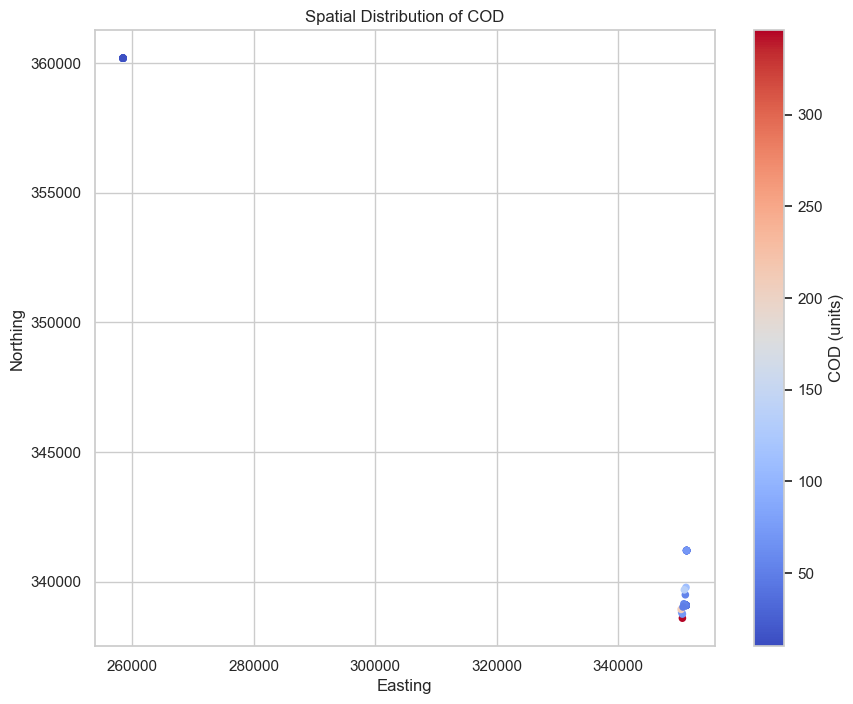

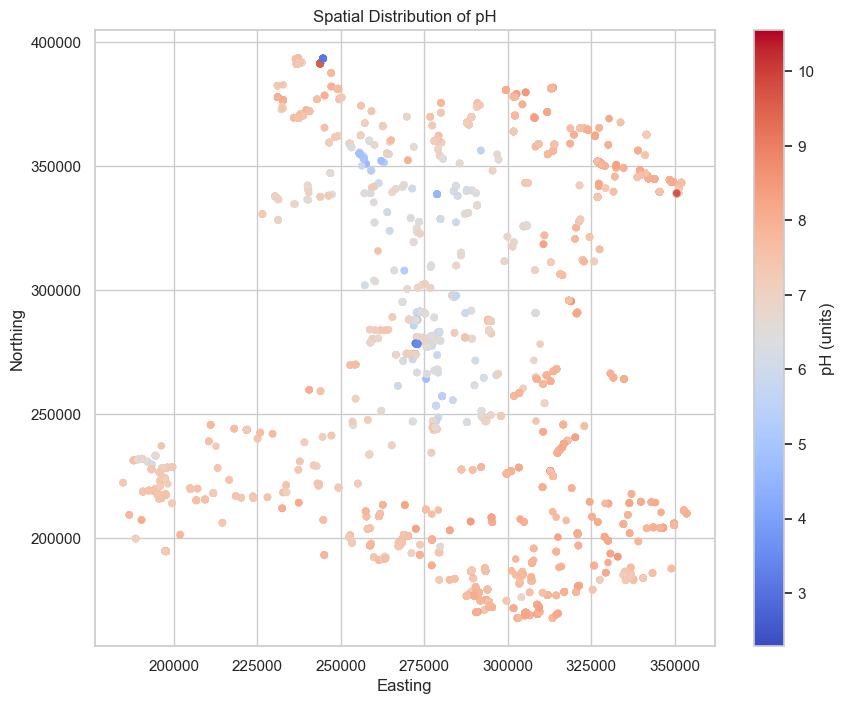

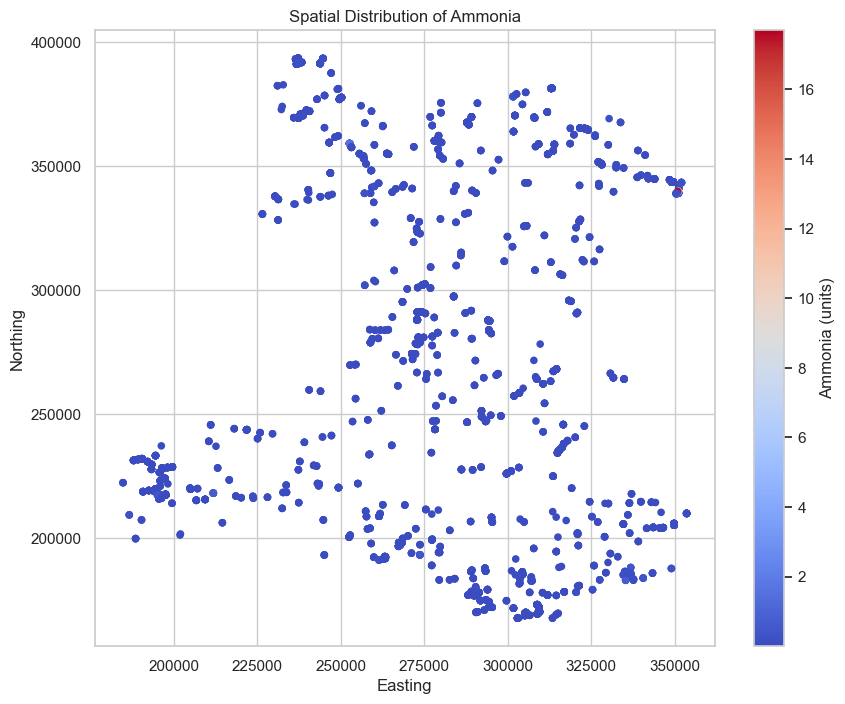

In [48]:
# Function to prepare and plot spatial distribution maps
def plot_spatial_distribution(parameter_name, data):
    plt.figure(figsize=(10, 8))
    param_data = data[data['parameter_name'] == parameter_name]
    plt.scatter(param_data['easting'], param_data['northing'],
                c=param_data['sample_value'], cmap='coolwarm', s=20)
    plt.colorbar(label=f'{parameter_name} (units)')
    plt.title(f'Spatial Distribution of {parameter_name}')
    plt.xlabel('Easting')
    plt.ylabel('Northing')
    plt.show()

# Plotting the spatial distribution of BOD
plot_spatial_distribution('BOD', data)

# Plotting the spatial distribution of COD
plot_spatial_distribution('COD', data)

# Plotting the spatial distribution of pH
plot_spatial_distribution('pH', data)

# Plotting the spatial distribution of Ammonia
plot_spatial_distribution('Ammonia', data)
